<a href="https://colab.research.google.com/github/Alfikriangelo/MachineLearningTasks/blob/main/11thWeekTask/Data_Dummy_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score,confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Generate Dummy Data
def create_dummy_data(samples=1000):
    np.random.seed(42)
    income = np.random.randint(2000, 10000, samples)
    expenses = np.random.randint(1000, 7000, samples)
    debt = np.random.randint(0, 5000, samples)
    savings = np.random.randint(0, 20000, samples)
    credit_score = np.random.randint(300, 850, samples)

    # Financial condition: 1 if savings > debt and income > expenses, else 0
    labels = (savings > debt) & (income > expenses)
    labels = labels.astype(int)

    data = pd.DataFrame({
        "Monthly Income": income,
        "Monthly Expenses": expenses,
        "Debt": debt,
        "Savings": savings,
        "Credit Score": credit_score,
        "Target": labels
    })
    return data

In [15]:
# Generate data
data = create_dummy_data()

In [16]:
print(data.head())

   Monthly Income  Monthly Expenses  Debt  Savings  Credit Score  Target
0            9270              2015    21     2014           454       1
1            9603              2824  4569     9833           648       1
2            2860              5469  3191     7896           750       0
3            7390              4136  2353      204           472       0
4            7226              3193  4799    16965           309       1


In [17]:
# Split features and target
X = data.drop(columns=["Target"])
y = data["Target"]

In [18]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# PyTorch Tensors for MLP
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.long)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long)

In [21]:
# PyTorch MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons_per_layer, activation_fn):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size

        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_features, neurons_per_layer))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            in_features = neurons_per_layer

        layers.append(nn.Linear(neurons_per_layer, 2))  # Output layer (binary classification)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [22]:
# Train PyTorch Model
def train_model(model, X_train, y_train, X_test, y_test, epochs, lr, batch_size):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
    )

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

In [23]:
# Hyperparameter options
hidden_layers_options = [1, 2, 3]
neurons_per_layer_options = [16, 32, 64]
activation_functions = ['relu', 'sigmoid']
epochs_options = [25, 50, 250]
learning_rates = [0.1, 0.001, 0.0001]
batch_sizes = [64, 128, 256]

# Results storage
results = []

In [24]:
# Iterate over all combinations of hyperparameters
for hidden_layers, neurons_per_layer, activation_fn, epochs, lr, batch_size in itertools.product(
    hidden_layers_options,
    neurons_per_layer_options,
    activation_functions,
    epochs_options,
    learning_rates,
    batch_sizes,
):
    # Initialize model with current hyperparameters
    model = MLP(X_train_torch.shape[1], hidden_layers, neurons_per_layer, activation_fn)

    # Train model
    train_model(model, X_train_torch, y_train_torch, X_test_torch, y_test_torch, epochs, lr, batch_size)

    # Evaluate model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_torch)
        _, predictions = torch.max(outputs, 1)
        accuracy = (predictions == y_test_torch).float().mean().item()

    # Save results
    results.append({
        'hidden_layers': hidden_layers,
        'neurons_per_layer': neurons_per_layer,
        'activation_fn': activation_fn,
        'epochs': epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'accuracy': accuracy
    })

In [25]:
# Sort results by accuracy
sorted_results = sorted(results, key=lambda x: x['accuracy'], reverse=True)

In [26]:
# Print top 5 configurations
print("Top 5 Hyperparameter Configurations:")
for result in sorted_results[:5]:
    print(result)

Top 5 Hyperparameter Configurations:
{'hidden_layers': 1, 'neurons_per_layer': 16, 'activation_fn': 'relu', 'epochs': 250, 'learning_rate': 0.1, 'batch_size': 128, 'accuracy': 1.0}
{'hidden_layers': 1, 'neurons_per_layer': 16, 'activation_fn': 'sigmoid', 'epochs': 250, 'learning_rate': 0.1, 'batch_size': 128, 'accuracy': 1.0}
{'hidden_layers': 1, 'neurons_per_layer': 32, 'activation_fn': 'relu', 'epochs': 250, 'learning_rate': 0.1, 'batch_size': 128, 'accuracy': 1.0}
{'hidden_layers': 1, 'neurons_per_layer': 32, 'activation_fn': 'relu', 'epochs': 250, 'learning_rate': 0.1, 'batch_size': 256, 'accuracy': 1.0}
{'hidden_layers': 1, 'neurons_per_layer': 32, 'activation_fn': 'sigmoid', 'epochs': 50, 'learning_rate': 0.1, 'batch_size': 64, 'accuracy': 1.0}


In [27]:
# TensorFlow Model
model_tf = Sequential([
    Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_tf.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.6063 - accuracy: 0.5869 - loss: 0.6789 - val_AUC: 0.7409 - val_accuracy: 0.7312 - val_loss: 0.6347
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7488 - accuracy: 0.7132 - loss: 0.6052 - val_AUC: 0.8033 - val_accuracy: 0.7250 - val_loss: 0.5963
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8034 - accuracy: 0.7852 - loss: 0.5609 - val_AUC: 0.8477 - val_accuracy: 0.7250 - val_loss: 0.5594
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8384 - accuracy: 0.8005 - loss: 0.5151 - val_AUC: 0.8750 - val_accuracy: 0.7625 - val_loss: 0.5203
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8508 - accuracy: 0.8036 - loss: 0.4801 - val_AUC: 0.8894 - val_accuracy: 0.7937 - val_loss: 0.4852
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8759 - accuracy: 0.8199 - loss: 0.4524 - val_AUC: 0.9005 - val_accuracy: 0.8062 - val_loss: 0.4497
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.899

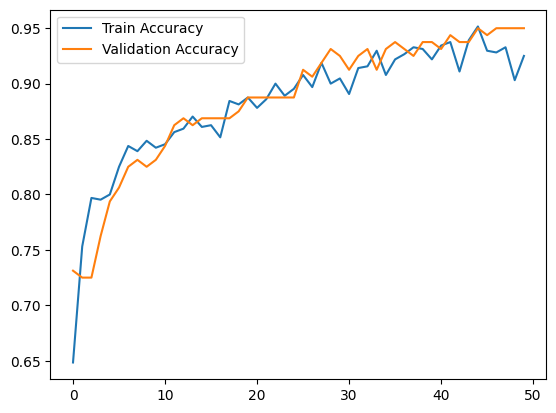

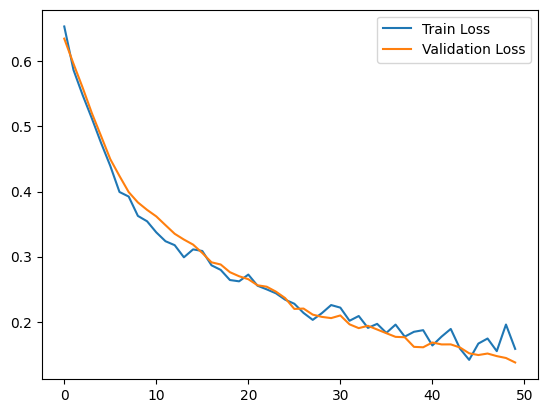

In [28]:
# Plot Accuracy and Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [29]:
# Evaluate the TensorFlow Model
test_loss, test_accuracy, test_auc = model_tf.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}, AUC: {test_auc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9945 - accuracy: 0.9552 - loss: 0.1079  
Test Accuracy: 0.95, AUC: 1.00


In [30]:
# Predictions
y_pred = model_tf.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_binary))
print("AUC:", roc_auc_score(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        70
           1       0.95      0.98      0.96       130

    accuracy                           0.95       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.95      0.95       200

AUC: 0.9958241758241758


Confusion Matrix:
[[ 63   7]
 [  3 127]]


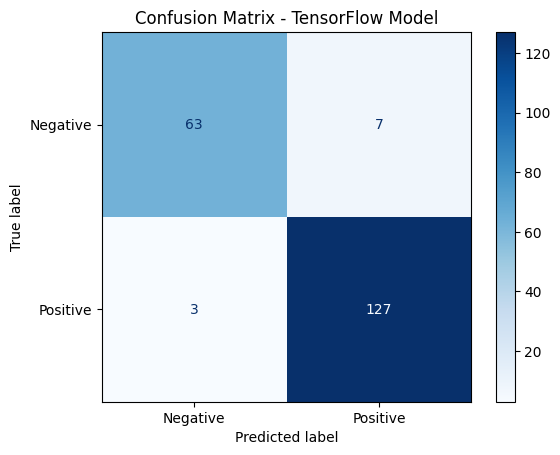

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Display Confusion Matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - TensorFlow Model")
plt.show()
